In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pymystem3 import Mystem
from stop_words import get_stop_words
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import gensim
from gensim.models import word2vec
from sklearn.model_selection import cross_val_predict
import re
import string
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

from keras.layers import Dense, Input, Embedding, Dropout, GRU, Bidirectional
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization

In [2]:
ads = pd.read_csv('/Users/admin/Documents/contextAdvertising1.csv')

In [3]:
ads.shape

(799999, 3)

In [4]:
ads.head()

,atitle,atext,adomain
0,Клуб активного отдыха «0.67»,Детский пейнтбол. Спортивный пейнтбол. Тактиче...,0-67.relax.by
1,Антигравитационный чехол IPhone 5,Успейте купить антигравитационный чехол для IP...,0-antigravity.ru
2,Антигравитационный чехол купить!,Антигравитационный чехол для телефона купить з...,0-antigravity.ru
3,Беспроцентный заем от Moneyveo,Без справок! Получите до 3 000 грн. на карту п...,0-credit.moneyveo.ua
4,Беспроцентный заем сотруднику,Акция! Получите Кредит Онлайн под 0%. Без Спра...,0-credit.moneyveo.ua


In [5]:
ads.nunique()

atitle     571923
atext      350006
adomain     19181
dtype: int64

In [6]:
(ads['atitle'] + ads['atext']).nunique()

792924

In [7]:
unique_adstext =ads.drop_duplicates(subset = ['atext'], keep=False)

In [8]:
unique_adstext.nunique()

atitle     234515
atext      323003
adomain      4838
dtype: int64

In [9]:
#it appears that even after we remove duplicate ads texts, we still have duplicate titles 
unique_adstext['atitle'].nunique()

234515

In [10]:
unique =unique_adstext.drop_duplicates(subset = ['atitle'], keep=False)

In [11]:
unique.nunique()

atitle     204601
atext      204601
adomain      4589
dtype: int64

In [12]:
unique.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204601 entries, 0 to 772521
Data columns (total 3 columns):
atitle     204601 non-null object
atext      204601 non-null object
adomain    204601 non-null object
dtypes: object(3)
memory usage: 6.2+ MB


In [13]:
unique.head()

,atitle,atext,adomain
0,Клуб активного отдыха «0.67»,Детский пейнтбол. Спортивный пейнтбол. Тактиче...,0-67.relax.by
1,Антигравитационный чехол IPhone 5,Успейте купить антигравитационный чехол для IP...,0-antigravity.ru
2,Антигравитационный чехол купить!,Антигравитационный чехол для телефона купить з...,0-antigravity.ru
3,Беспроцентный заем от Moneyveo,Без справок! Получите до 3 000 грн. на карту п...,0-credit.moneyveo.ua
4,Беспроцентный заем сотруднику,Акция! Получите Кредит Онлайн под 0%. Без Спра...,0-credit.moneyveo.ua


In [14]:
unique['atext'][:5]

0    Детский пейнтбол. Спортивный пейнтбол. Тактиче...
1    Успейте купить антигравитационный чехол для IP...
2    Антигравитационный чехол для телефона купить з...
3    Без справок! Получите до 3 000 грн. на карту п...
4    Акция! Получите Кредит Онлайн под 0%. Без Спра...
Name: atext, dtype: object

In [15]:
type(unique['atext'])

pandas.core.series.Series

In [16]:
#include all the punctuation signs\n",
def punctuation_remover(row):
    punctuation = '!"#$&\'()*+,-./:;<=>?@[\\]^_`{|}~«»'
    
    punctuationNoPeriod = "[" + re.sub("\.","", punctuation) + "]"
    row = re.sub(punctuationNoPeriod, " ", str(row))
    #to remove double white spaces and create space after %,
    row = row.replace('  ', ' ')
    row = row.replace('%', '% ')
    return row.strip()


In [17]:
punctuation_remover(unique['atext'][0])

'Детский пейнтбол Спортивный пейнтбол Тактический пейнтбол Выездные игры'

In [18]:
# remove punctuation from the ads text
unique['atext'] = unique['atext'].apply(punctuation_remover)

In [19]:
unique['atitle'] = unique['atitle'].apply(punctuation_remover)

In [20]:
unique['atitle'][:5]

0           Клуб активного отдыха 0 67
1    Антигравитационный чехол IPhone 5
2      Антигравитационный чехол купить
3       Беспроцентный заем от Moneyveo
4        Беспроцентный заем сотруднику
Name: atitle, dtype: object

In [21]:
unique['atext'].iloc[0]

'Детский пейнтбол Спортивный пейнтбол Тактический пейнтбол Выездные игры'

In [22]:
unique = unique.drop_duplicates(subset = ['atitle'], keep=False)

In [23]:
unique = unique.drop_duplicates(subset = ['atext'], keep=False)

In [24]:
unique.nunique()

atitle     200718
atext      200718
adomain      4534
dtype: int64

m = Mystem()
def text_parser(series, lemmatize=True): # do lemmatization if true 
    series_copy = series.copy()
 
    # access each ad by index
    for index in series_copy.index:
        
        text = series_copy[index]
        if lemmatize ==True:
            lemmas = m.lemmatize(text)

            lem_no_punct = [lemma for lemma in lemmas if lemma!= ' '
                           and lemma != '\n']
            
            output = lem_no_punct
        else:
            output = text.split()
        series_copy[index] =output
    return series_copy

In [25]:
m = Mystem()
def text_parser(series, lemmatize=True): # do lemmatization if true 
    series_copy = series.copy()
 
    # access each ad by index
    for index in series_copy.index:
        ad_string = ''
        text = series_copy[index]
        if lemmatize == True:
            lemmas = m.lemmatize(text)
            for count, lemma in enumerate(lemmas):
                if (lemma !=  ' ' and lemma != '\n' and count < len(lemmas)):
                    ad_string += lemma.lower() +' '
                                
        else:
            for number, word in enumerate(text):  
                if number <len(text)-1:
                    ad_string+=word +' '
            ad_string = ad_string.lower()
            ad_string.strip()        
            #now it's actually a list of strings        
            ad_string = ad_string.split() 
            
        series_copy[index] =ad_string
    return series_copy

In [26]:
unique_lem = unique.copy()
unique_lem['atitle'] = text_parser(unique['atitle'])

In [27]:
unique_lem['atext'] = text_parser(unique['atext'])

In [28]:
unique_lem.head()

,atitle,atext,adomain
0,клуб активный отдых 0 67,детский пейнтбол спортивный пейнтбол тактическ...,0-67.relax.by
1,антигравитационный чехол IPhone 5,успевать купить антигравитационный чехол для I...,0-antigravity.ru
3,беспроцентный заем от Moneyveo,без справка получать до 3 000 грн на карта под...,0-credit.moneyveo.ua
4,беспроцентный заем сотрудник,акция получать кредит онлайн под 0 % без спр...,0-credit.moneyveo.ua
11,Аnti Gravity Case,Аnti gravity case – уникальный антигравитаци...,0-gravity.online-shop-2017.ru


In [29]:
unique_lem.shape

(200718, 3)

In [30]:
unique_lem = unique_lem.drop_duplicates(subset = ['atitle'], keep=False)

In [31]:
unique_lem = unique_lem.drop_duplicates(subset = ['atext'], keep=False)

In [32]:
unique_lem.shape

(195820, 3)

In [33]:
unique_lem.nunique()

atitle     195820
atext      195820
adomain      4492
dtype: int64

In [34]:
unique_lem = unique_lem.drop_duplicates(keep=False)

In [35]:
unique_lem.nunique()

atitle     195820
atext      195820
adomain      4492
dtype: int64

In [36]:
unique_lem.shape

(195820, 3)

In [37]:
len(set(unique_lem['atext']))

195820

In [38]:
len(set(unique_lem['atitle']))

195820

In [39]:
len(unique_lem['atitle'])

195820

In [40]:
len(unique_lem['atext'])

195820

In [41]:
unique_lem.isnull().sum()

atitle     0
atext      0
adomain    0
dtype: int64

In [42]:
unique_lem['atitle'] = unique_lem['atitle'].apply(lambda x: x.split())

In [43]:
unique_lem['atext'] = unique_lem['atext'].apply(lambda x: x.split())

In [44]:
X = unique_lem['atext']
y = unique_lem['atitle']

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [46]:
merged_list = X_train + y_train

# Training Word2Vec

In [47]:
model = word2vec.Word2Vec(
    merged_list,
    workers=4,     
    min_count=5,   
    window=50,      
    sg=0,          
    sample=1e-4 ,  
    size=300,      
    hs=1           
)


In [48]:
vocab = model.wv.vocab.keys()
print(len(vocab))

21000


In [49]:
def tsne_plot(model):
    #Creates and TSNE model and plots it
    
    labels = []
    tokens = []

    for word in model.wv.vocab:
        if model.wv.vocab[word].count > 1000:
            tokens.append(model[word])
            labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=108)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(20, 20)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

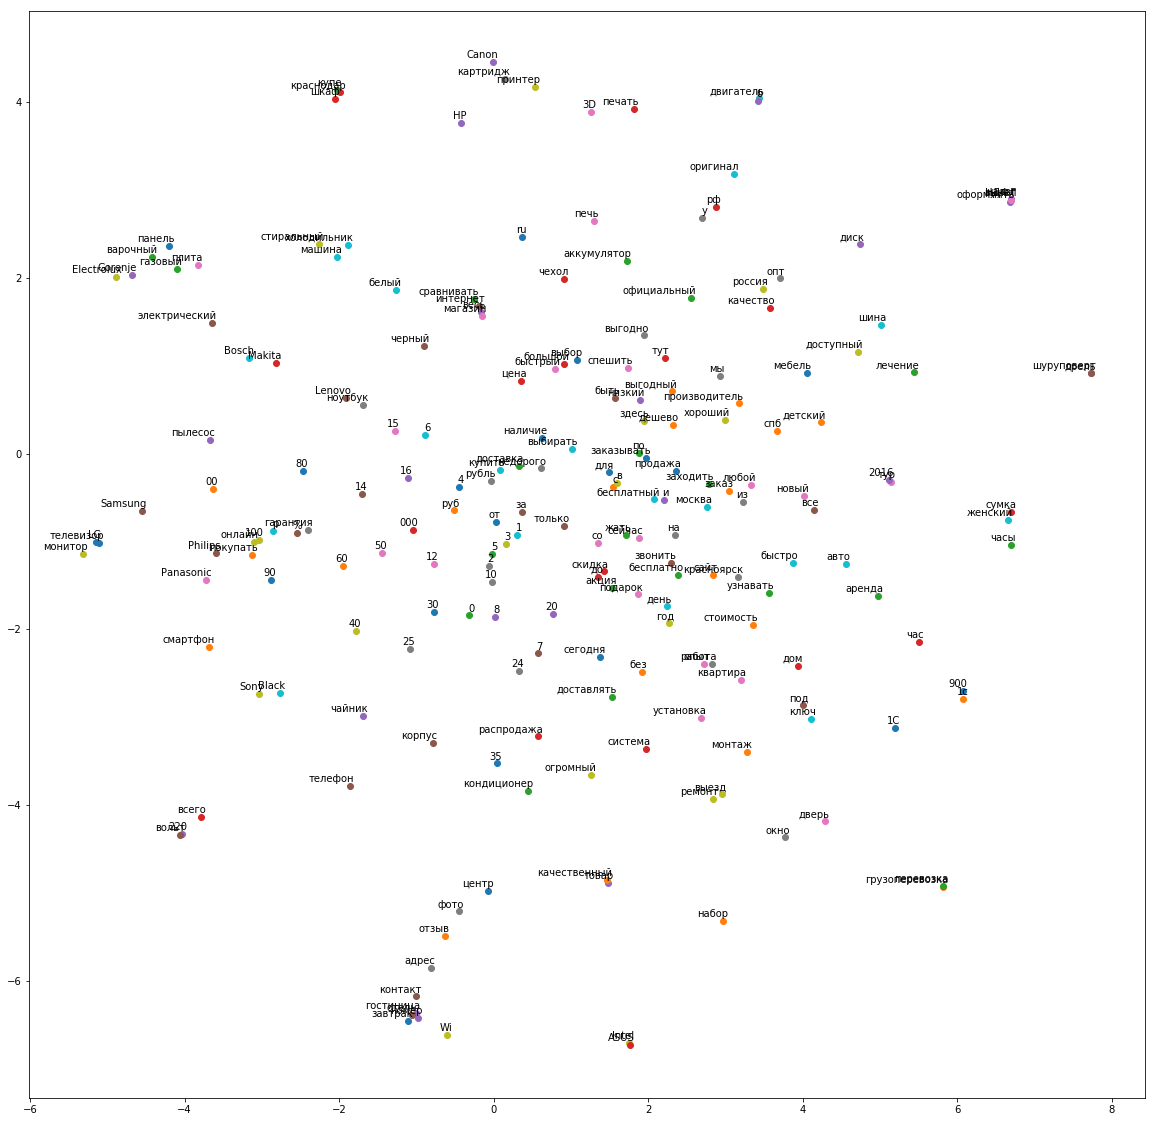

In [50]:
tsne_plot(model)

# Sample For Evaluation

In [51]:
indices = X_test.index

In [52]:
test_df = pd.DataFrame(X_test, index = indices)

In [53]:
test_df.head()

,atext
379691,"[электрочайник, Zigmund, Shtain, KE, 81, SD, 1..."
520472,"[сабвуфер, огромный, ассортимент, бесплатный, ..."
19942,"[Onkyo, Tx, nr545, Black, в, наличие, быстрый,..."
153486,"[шаблон, ордер, входить, в, состав, сборник, 1..."
700377,"[шпаклевка, финишный, белый, сравнивать, цена,..."


In [54]:
test_df['atitle'] = y_test

In [55]:
test_df.shape

(58746, 2)

In [56]:
# we can't fit all the examples in our memory

test_sample = test_df.sample(1000)

In [57]:
test_text_sample = test_sample['atext']
test_title_sample = test_sample['atitle']

In [58]:
from sklearn.preprocessing import normalize


def result_vector(text):
    result = np.zeros(300)
    count = 0
    for word in text:
        if word in vocab:
            result+=model.wv[word]
            count+=1
    if count == 0:
        return None
    #result = (result / count).reshape(1, -1)
    result = normalize(result.reshape(1, -1))     
    return result

In [59]:
ad_vectors = []
for ad_text in test_text_sample:
        vector = result_vector(ad_text)
        if vector is not None:
            ad_vectors.append(vector)
        else:
            ad_vectors.append('M')

In [60]:
title_vectors = []
for ad_title in test_title_sample:
    vector = result_vector(ad_title)
    if vector is not None:
        title_vectors.append(vector)
    else:
        title_vectors.append('M')

In [61]:
def cosine_calculator(vector_one, other_vectors):
    cosines = []
    for each in other_vectors:
        if each != 'M':
            sim_score = cosine_similarity(vector_one, each)
            cosines.extend(sim_score) 
        else:
            cosines.append('M')
    return cosines

In [62]:
def rank_checker(first_vector_set, other_vectors, smpl_df, number):
    cosines_results = cosine_calculator(first_vector_set[number], other_vectors)
    series = pd.Series(cosines_results, index =smpl_df.index)
    
    #cleaning the series for sorting, 'M' stands for missing, was added if no words in the text were found in w2v vocab
    cleaned = series[series != 'M']
    sorted_df = cleaned.sort_values(ascending=False)
    sorted_index = sorted_df.index
    
    for rank, entry in enumerate(sorted_index):
        if entry == smpl_df.index[number]:
            return rank

In [63]:
ranks = []
for row in range(len(test_sample)):
    rank = rank_checker(ad_vectors, title_vectors, test_sample, row)
    ranks.append(rank)

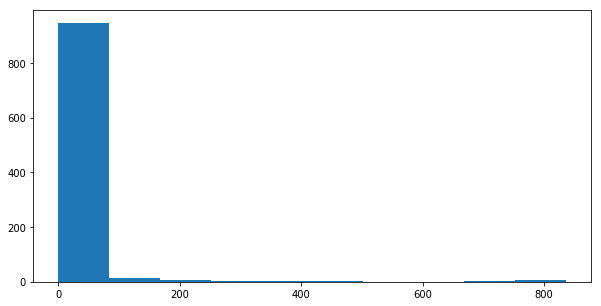

In [64]:
plt.figure(figsize=(10, 5))
plt.hist([rank for rank in ranks if rank is not None])
plt.show()

In [65]:
#average rank
sum([rank for rank in ranks if rank is not None])/ len([rank for rank in ranks if rank is not None])

18.624493927125506

In [66]:
small = []
for rank in ranks:
    if rank is not None and rank <=10:
        small.append(rank) 

In [67]:
# proportion ranked as 
len(small) / len([rank for rank in ranks if rank is not None])

0.8927125506072875

# Supervised Solution

In [68]:
training_df = pd.DataFrame()
training_df['text vectors'] = X_train 
training_df['title vectors'] = y_train

In [69]:
test_df = pd.DataFrame()
test_df['text vectors'] = X_test
test_df['title vectors'] = y_test

In [70]:
training_df.shape

(137074, 2)

In [71]:
test_df.shape

(58746, 2)

In [72]:
def mixed_df_creator(df):
    
    df_copy = df.copy()
    df_copy = df.reset_index(drop=True)
    
    first_half = df_copy.iloc[:int(len(df_copy)/2)]
    second_half = df_copy.iloc[int(len(df_copy)/2):]
    
    shuffled_titles = shuffle(second_half['title vectors'])
    shuffled_titles = shuffled_titles.reset_index(drop=True)
    
    second_half = second_half.reset_index(drop=True)
    second_half['title vectors'] = shuffled_titles
    
    first_half['pair class'] = 1
    second_half['pair class'] = 0
    
    #sim_score_one = first_half.apply(cosine_between_rows, axis = 1)
    #sim_score_two = second_half.apply(cosine_between_rows, axis = 1)
    
    #print('Mean cosine similarity score: first half', np.mean(sim_score_one))
    #print('Mean cosine similarity score: second half', np.mean(sim_score_two))
    
    concat_result = pd.concat([first_half, second_half], axis=0, ignore_index = True)
    
    return concat_result

In [73]:
training_df_mixed = mixed_df_creator(training_df)

In [74]:
test_df_mixed = mixed_df_creator(test_df)

In [75]:
training_df_mixed.head()

,text vectors,title vectors,pair class
0,"[lg, sh7b, от, 819, 00, доставка]","[lg, sh7b]",1
1,"[нужный, перевод, медицинский, документация, к...","[перевод, медицинский, документация]",1
2,"[результат, на, 3, день, зубной, паста, крест,...","[зубной, паста, крест]",1
3,"[массив, бук, и, дуб, древесный, шпон, ciplex,...","[межкомнатный, дверь, из, россия]",1
4,"[купить, Gerat, лента, пробивной, Gerat, 19мм,...","[Gerat, 19мм, 3, 2мм, 30м, 50327]",1


In [76]:
training_df_mixed.shape

(137074, 3)

In [77]:
len(result_vector(training_df_mixed.iloc[0, 0])[0])

300

In [78]:
# vectorization of the ads text
text_vectors = []
for row in range(len(training_df_mixed)):
    vector = result_vector(training_df_mixed.iloc[row, 0])
    if vector is not None:  
        text_vectors.append(vector[0])
    else:
        text_vectors.append('M')

In [79]:
training_df_mixed_vectorized = training_df_mixed.copy()

In [80]:
training_df_mixed_vectorized['text vectors'] = text_vectors

In [81]:
# vectorization of the ads text
text_vectors_test = []
for row in range(len(test_df_mixed)):
    vector = result_vector(test_df_mixed.iloc[row, 0])
    if vector is not None:  
        text_vectors_test.append(vector[0])
    else:
        text_vectors_test.append('M')

In [82]:
test_df_mixed_vectorized = test_df_mixed.copy()

In [83]:
test_df_mixed_vectorized['text vectors'] = text_vectors_test

In [84]:
# vectorization of the ads title
title_vectors_tr = []
for row in range(len(training_df_mixed)):
    vector = result_vector(training_df_mixed.iloc[row, 1])
    if vector is not None:  
        title_vectors_tr.append(vector[0])
    else:
        title_vectors_tr.append('M')

In [85]:
training_df_mixed_vectorized['title vectors'] = title_vectors_tr

In [86]:
# vectorization of the ads title
title_vectors_test = []
for row in range(len(test_df_mixed)):
    vector = result_vector(test_df_mixed.iloc[row, 1])
    if vector is not None:  
        title_vectors_test.append(vector[0])
    else:
        title_vectors_test.append('M')

In [87]:
test_df_mixed_vectorized['title vectors'] = title_vectors_test

In [88]:
# remove vectors with that are comprised exclusively of the words that are missing from our vocabulary

training_df_mixed_vectorized= training_df_mixed_vectorized[training_df_mixed_vectorized['text vectors'] != 'M']
training_df_mixed_vectorized = training_df_mixed_vectorized[training_df_mixed_vectorized['title vectors'] != 'M']

test_df_mixed_vectorized= test_df_mixed_vectorized[test_df_mixed_vectorized['text vectors'] != 'M']
test_df_mixed_vectorized = test_df_mixed_vectorized[test_df_mixed_vectorized['title vectors'] != 'M']

In [89]:
training_df_mixed_vectorized.head()

,text vectors,title vectors,pair class
0,"[-0.0027742561401566217, 0.03461939136532193, ...","[0.024540292744303926, -0.009632373470928846, ...",1
1,"[-0.0844200928998112, 0.002986090694611397, 0....","[-0.0391659416847272, -0.03676063017640007, 0....",1
2,"[-0.06966013043018048, -0.025306771094227645, ...","[0.027623420126889384, 0.04848150487022256, 0....",1
3,"[-0.06797899979074326, 0.033551506469868396, -...","[-0.03887591419698565, 0.10304372088306155, -0...",1
4,"[-0.014834204166066456, 0.004732871588807515, ...","[0.03466587521078149, 0.04273233717066049, -0....",1


In [90]:
test_df_mixed_vectorized.head()

,text vectors,title vectors,pair class
0,"[-0.021196018095643625, 0.021109890762787367, ...","[-0.06631127555266361, 0.03698774453357387, 0....",1
1,"[-0.13091671909286354, -0.06633060151462958, -...","[-0.061542388023199585, 0.024764664441110484, ...",1
2,"[-0.051841686368287454, 0.0816106348686147, 0....","[-0.017910044585391926, 0.023081066257000217, ...",1
3,"[-0.0616991797581098, -0.05254760266971141, -0...","[-0.022093441067550658, 0.01875982351413886, -...",1
4,"[-0.047522453786995704, 0.016083370700846717, ...","[-0.021573949851945103, 0.027799315254393803, ...",1


In [91]:
def cosine_between_rows(row):
    sim = cosine_similarity(row['text vectors'].reshape(1, -1), row['title vectors'].reshape(1, -1))
    return sim

# Cosine Consistency Check

In [92]:
sim_score_one = training_df_mixed_vectorized.iloc[:int(len(training_df_mixed_vectorized)/2)].apply(cosine_between_rows, axis = 1)
sim_score_two = training_df_mixed_vectorized.iloc[int(len(training_df_mixed_vectorized)/2):].apply(cosine_between_rows, axis = 1)

print('Mean cosine similarity score: first half', np.mean(sim_score_one))
print('Mean cosine similarity score: second half', np.mean(sim_score_two))

Mean cosine similarity score: first half [[0.77957209]]
Mean cosine similarity score: second half [[0.23982956]]


In [93]:
sim_score_one_test = test_df_mixed_vectorized.iloc[:int(len(test_df_mixed_vectorized)/2)].apply(cosine_between_rows, axis = 1)
sim_score_two_test = test_df_mixed_vectorized.iloc[int(len(test_df_mixed_vectorized)/2):].apply(cosine_between_rows, axis = 1)

print('Mean cosine similarity score: first half', np.mean(sim_score_one_test))
print('Mean cosine similarity score: second half', np.mean(sim_score_two_test))

Mean cosine similarity score: first half [[0.77275878]]
Mean cosine similarity score: second half [[0.24336623]]


In [94]:
training_df_mixed.head()

,text vectors,title vectors,pair class
0,"[lg, sh7b, от, 819, 00, доставка]","[lg, sh7b]",1
1,"[нужный, перевод, медицинский, документация, к...","[перевод, медицинский, документация]",1
2,"[результат, на, 3, день, зубной, паста, крест,...","[зубной, паста, крест]",1
3,"[массив, бук, и, дуб, древесный, шпон, ciplex,...","[межкомнатный, дверь, из, россия]",1
4,"[купить, Gerat, лента, пробивной, Gerat, 19мм,...","[Gerat, 19мм, 3, 2мм, 30м, 50327]",1


In [95]:
training_df_mixed.isnull().sum()

text vectors     0
title vectors    0
pair class       0
dtype: int64

In [96]:
training_df_mixed.head()

,text vectors,title vectors,pair class
0,"[lg, sh7b, от, 819, 00, доставка]","[lg, sh7b]",1
1,"[нужный, перевод, медицинский, документация, к...","[перевод, медицинский, документация]",1
2,"[результат, на, 3, день, зубной, паста, крест,...","[зубной, паста, крест]",1
3,"[массив, бук, и, дуб, древесный, шпон, ciplex,...","[межкомнатный, дверь, из, россия]",1
4,"[купить, Gerat, лента, пробивной, Gerat, 19мм,...","[Gerat, 19мм, 3, 2мм, 30м, 50327]",1


In [97]:
test_df_mixed.isnull().sum()

text vectors     0
title vectors    0
pair class       0
dtype: int64

In [98]:
def df_converter(df):
    resultant_lists = df['text vectors'].apply(list) + df['title vectors'].apply(list)
    
    #print length for checking the length of concatenated vectors
    print(len(resultant_lists.iloc[0]))
    
    arrays = np.array(list(resultant_lists))
    return arrays

In [99]:
test_sample.head()

,atext,atitle
681634,"[мфу, Oki, сравнивать, цена, весь, интернет, м...","[мфу, Oki]"
245968,"[купить, аккумулятор, на, KIA, доставка, по, б...","[аккумулятор, на, KIA, с, доставка]"
677647,"[ковролин, нева, тафт, сравнивать, цена, весь,...","[ковролин, нева, тафт]"
30041,"[купить, Electrolux, вытяжка, Electrolux, EFP6...","[вытяжка, Electrolux, EFP6411X]"
200262,"[краскопульт, Bosch, PFS, 5000E]","[PFS, 5000E, 9870p]"


In [100]:
test_sample.shape

(1000, 2)

In [101]:
all_training_vectors = df_converter(training_df_mixed_vectorized)

600


In [102]:
all_test_vectors = df_converter(test_df_mixed_vectorized)

600


In [103]:
new_y_training = training_df_mixed_vectorized['pair class']

In [104]:
new_y_test = test_df_mixed_vectorized['pair class']

# Sample for Parameter Finetuning

In [105]:
sample_training_df = training_df_mixed_vectorized.sample(10000)

In [106]:
sample_training_df.head()

,text vectors,title vectors,pair class
123733,"[-0.013602399312096352, -0.0055048723827680335...","[-0.01959503928326024, -0.016215580556794063, ...",0
134813,"[-0.001973661009058733, 0.11635021313813973, -...","[-0.0702424975738136, 0.05785772726890166, -0....",0
67695,"[-0.04658829938102245, -0.029769276412652902, ...","[0.056951598033105996, -0.011048820936507591, ...",1
65348,"[-0.04956321136175047, -0.03726876435152922, -...","[-0.02598522938787214, -0.10969580025408562, 0...",1
76211,"[-0.10424137574895415, -0.011810597929236437, ...","[0.016664435532191196, -0.029009996506786328, ...",0


In [107]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 150)
X_train_pca = pca.fit_transform(all_training_vectors)

In [108]:
print(sum(pca.explained_variance_ratio_))

0.8767455024690076


In [109]:
X_test_pca = pca.transform(all_test_vectors)

In [110]:
X_test_pca.shape

(58275, 150)

# Finetuning Models

In [111]:
sample_training_arrays = df_converter(sample_training_df)

600


In [112]:
sample_y = sample_training_df['pair class']

In [113]:
pca_sample = PCA(n_components = 150)
X_train_sample_pca = pca_sample.fit_transform(sample_training_arrays)

In [114]:
X_train_sample_pca.shape

(10000, 150)

In [115]:
print(sum(pca_sample.explained_variance_ratio_))

0.8793949951051466


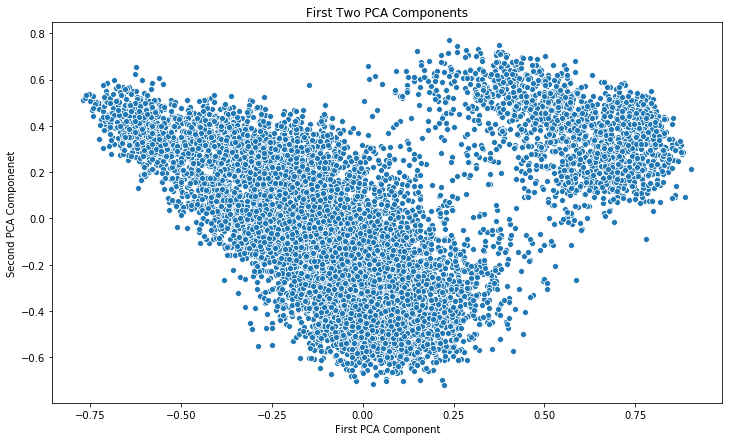

In [116]:
plt.figure(figsize=(12, 7))
plt.title('First Two PCA Components')
sns.scatterplot(X_train_sample_pca[:, 0], X_train_sample_pca[:, 1])
plt.xlabel('First PCA Component')
plt.ylabel('Second PCA Componenet')

plt.show()

In [117]:
from sklearn.linear_model import LogisticRegression

param_grid = [
    {'C': [1e-20, 1e-3,1e-3,  10, 1e2, 1e3],
    'penalty': ['l1', 'l2']}
]
lr = LogisticRegression()

grid_search = GridSearchCV(lr, param_grid, cv =3,
                          scoring= 'accuracy', verbose=1)

grid_search.fit(X_train_sample_pca, sample_y)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    2.1s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [1e-20, 0.001, 0.001, 10, 100.0, 1000.0], 'penalty': ['l1', 'l2']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [118]:
print('Best score', grid_search.best_score_)
print('Best parameters', grid_search.best_params_)

Best score 0.5167
Best parameters {'C': 10, 'penalty': 'l1'}


In [119]:
param_grid_rfc = [
    {'n_estimators': [100, 500, 700],
    'max_depth': [5, 8, 12, 20, 30]}
]
rfc = RandomForestClassifier(n_jobs = -1)

grid_search_rfc = GridSearchCV(rfc, param_grid_rfc, cv =3,
                          scoring= 'accuracy', verbose=0,
                          n_jobs = -1)

grid_search_rfc.fit(X_train_sample_pca, sample_y)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [100, 500, 700], 'max_depth': [5, 8, 12, 20, 30]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [120]:
print('Best score', grid_search_rfc.best_score_)
print('Best parameters', grid_search_rfc.best_params_)

Best score 0.8822
Best parameters {'max_depth': 30, 'n_estimators': 700}


In [121]:
param_grid_rfc = [
    {'n_estimators': [1000, 1200],
    'max_depth': [40, 50]}
]
rfc_one = RandomForestClassifier(n_jobs = -1)

grid_search_rfc_one = GridSearchCV(rfc, param_grid_rfc, cv =3,
                          scoring= 'accuracy', verbose=0,
                          n_jobs = -1)

grid_search_rfc_one.fit(X_train_sample_pca, sample_y)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [1000, 1200], 'max_depth': [40, 50]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [122]:
print('Best score', grid_search_rfc_one.best_score_)
print('Best parameters', grid_search_rfc_one.best_params_)

Best score 0.8853
Best parameters {'max_depth': 50, 'n_estimators': 1000}


In [123]:
from xgboost import XGBClassifier

param_grid_xgb = [
    {'n_estimators': [100, 500, 700],
    'max_depth': [2, 4, 6, 8],
    #'learning_rate': [1e-3, 0.5, 0.1],
    }
]
xgb = XGBClassifier(n_jobs = -1)

grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, cv =3,
                          scoring= 'accuracy', verbose=0,
                          n_jobs = -1)

grid_search_xgb.fit(X_train_sample_pca, sample_y)

GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [100, 500, 700], 'max_depth': [2, 4, 6, 8]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [124]:
print('Best score', grid_search_xgb.best_score_)
print('Best parameters', grid_search_xgb.best_params_)

Best score 0.9254
Best parameters {'max_depth': 8, 'n_estimators': 700}


In [126]:
param_grid_xgb_one = [
    {'n_estimators': [700, 1000],
    'learning_rate': [1e-3, 0.5, 0.1],
    }
]
xgb = XGBClassifier(n_jobs = -1, max_depth= 8)

grid_search_xgb_one = GridSearchCV(xgb, param_grid_xgb_one, cv =3,
                          scoring= 'accuracy', verbose=0,
                          n_jobs = -1)

grid_search_xgb_one.fit(X_train_sample_pca, sample_y)

GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [700, 1000], 'learning_rate': [0.001, 0.5, 0.1]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [127]:
print('Best score', grid_search_xgb_one.best_score_)
print('Best parameters', grid_search_xgb_one.best_params_)

Best score 0.9254
Best parameters {'learning_rate': 0.1, 'n_estimators': 700}


In [128]:
param_grid_xgb_two = [
    {'subsample': [0.25, 0.5, 1],
    }
]
xgb = XGBClassifier(n_jobs = -1, max_depth= 8, n_estimators=700, learning_rate=0.1, )

grid_search_xgb_two = GridSearchCV(xgb, param_grid_xgb_two, cv =3,
                          scoring= 'accuracy', verbose=0,
                          n_jobs = -1)

grid_search_xgb_two.fit(X_train_sample_pca, sample_y)

GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=700,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'subsample': [0.25, 0.5, 1]}], pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=0)

In [129]:
print('Best score', grid_search_xgb_two.best_score_)
print('Best parameters', grid_search_xgb_two.best_params_)

Best score 0.9271
Best parameters {'subsample': 0.5}


# Test Set

In [130]:
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score
lr_test = LogisticRegression(C= 10, penalty= 'l1')

lr_test.fit(X_train_pca, new_y_training)

print(lr_test.score(X_test_pca, new_y_test))

0.4978120978120978


In [131]:
rfc_test = RandomForestClassifier(n_jobs = -1, 
                            n_estimators = 1000,
                            max_depth = 50)

rfc_test.fit(X_train_pca, new_y_training)

print(rfc_test.score(X_test_pca, new_y_test))

0.9367824967824968


In [266]:
rfc_pred = rfc_test.predict(X_test_pca)
print(confusion_matrix(new_y_test, rfc_pred ))

[[27838  1286]
 [ 2398 26753]]


In [267]:
print(f1_score(new_y_test, rfc_pred ))

0.9355831439062774


In [268]:
print(recall_score(new_y_test, rfc_pred ))

0.9177386710575967


In [269]:
print(precision_score(new_y_test, rfc_pred ))

0.9541353115303685


In [132]:
xgb_test = XGBClassifier(n_estimators = 700,
                        max_depth = 6,
                        learning_rate= 0.1,
                        subsample = 0.5)

xgb_test.fit(X_train_pca, new_y_training)

print(xgb_test.score(X_test_pca, new_y_test))

0.9616816816816817


In [133]:
print(xgb_test.score(X_test_pca, new_y_test))

0.9616816816816817


In [134]:
len(X_test_pca)

58275

In [135]:
len(test_df_mixed['text vectors'])

58746

In [136]:
predictions = pd.DataFrame(test_df_mixed['text vectors'].iloc[:200])
predictions['title vectors'] = test_df_mixed['title vectors'].iloc[:200]
predictions['pair class'] = test_df_mixed['pair class'].iloc[:200]
predictions['predicted class'] = xgb_test.predict_proba(X_test_pca[:200])[:, 1]

In [137]:
xgb_test.predict_proba(X_test_pca[0].reshape(1, -1))[:, 1]

array([0.986152], dtype=float32)

In [138]:
predictions.iloc[:20, :]

,text vectors,title vectors,pair class,predicted class
0,"[электрочайник, Zigmund, Shtain, KE, 81, SD, 1...","[KE, 81, SD, 119, 00, р]",1,0.986152
1,"[сабвуфер, огромный, ассортимент, бесплатный, ...","[сабвуфер, купить, в, красноярск]",1,0.996636
2,"[Onkyo, Tx, nr545, Black, в, наличие, быстрый,...","[Onkyo, Tx, nr545, Black, всего, 42390р]",1,0.984310
3,"[шаблон, ордер, входить, в, состав, сборник, 1...","[шаблон, ордер]",1,0.990837
4,"[шпаклевка, финишный, белый, сравнивать, цена,...","[шпаклевка, финишный, белый]",1,0.764447
5,"[акция, аккумулятор, на, Toyota, Corolla, розн...","[аккумулятор, на, Toyota, Corolla]",1,0.994654
6,"[пила, торцовочный, только, сегодня, за, 6499,...","[пила, торцовочный, Hammer]",1,0.982314
7,"[по, низкий, цена, шуруповерт, макит, в, спб, ...","[купить, шуруповерт, макит, в, спб]",1,0.990650
8,"[купить, Makita, уровень, Makita, Skr200z, 174...","[уровень, Makita, Skr200z, 174614]",1,0.997554
9,"[дезодорант, регулир, потоотделение, сравниват...","[дезодорант, регулир, потоотделение]",1,0.980606


In [139]:
predictions = pd.DataFrame(test_df_mixed['text vectors'].iloc[-200:])
predictions['title vectors'] = test_df_mixed['title vectors'].iloc[-200:]
predictions['pair class'] = test_df_mixed['pair class'].iloc[-200:]
predictions['predicted class'] = xgb_test.predict_proba(X_test_pca[-200:])[:, 1]

In [140]:
X_test_pca[0].shape

(150,)

In [142]:
predictions.iloc[:20, :]

,text vectors,title vectors,pair class,predicted class
58546,"[адресный, табличка, изготовление, 1, день, бо...","[купить, заколка, для, волос]",0,0.025990
58547,"[телефон, Highscreen, Boost, сравнивать, цена,...","[кроссовок, пума]",0,0.001028
58548,"[электродный, котел, сравнивать, цена, весь, и...","[получать, 380000, в, кредит]",0,0.002775
58549,"[быть, в, наличие, сейчас, рубанок, BLACK, AND...","[такси, стоимость, звонить]",0,0.051416
58550,"[мфу, Brother, DCP, J100, 360, 86, р, гарантия...","[купить, кофе, мексика, марагоджип]",0,0.000308
58551,"[наушник, вкладыш, большой, выбор, наушник, по...","[недорогой, такси, в, спб, от, 125, р]",0,0.017126
58552,"[звонить, сейчас, купить, дом, на, авито, стро...","[panasonic, nn, cs894bzpe]",0,0.001470
58553,"[имплантация, и, профессиональный, протезирова...","[коврик, для, мышь, Defender]",0,0.066370
58554,"[холодильник, Liebherr, CTP, 3316, низкий, цен...","[Microlab, FC, 730, 237, 12, р]",0,0.000760
58555,"[жакет, теплый, сравнивать, цена, весь, интерн...","[как, бороться, с, клещ]",0,0.001885


In [143]:
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score

xgb_pred = xgb_test.predict(X_test_pca)
print(f1_score(new_y_test, xgb_pred ))

0.9615669265589233


In [144]:
from sklearn.metrics import confusion_matrix
confusion_matrix(new_y_test, xgb_pred)

array([[28108,  1016],
       [ 1217, 27934]])

In [145]:
precision_score(new_y_test, xgb_pred)

0.9649050086355786

In [146]:
recall_score(new_y_test, xgb_pred)

0.9582518609996227

In [147]:
sample_test_df_checking = test_df.sample(1000)

In [148]:
sample_test_df_checking = sample_test_df_checking.reset_index(drop=True)

In [149]:
sample_test_df_checking.head()

,text vectors,title vectors
0,"[холодильник, с, морозильник, Candy, CKBS, 618...","[CKBS, 6180, W, 599, 00, р]"
1,"[смартфон, Microsoft, сравнивать, цена, весь, ...","[смартфон, Microsoft]"
2,"[наушник, Ritmix, RH, 125, 29, 10, р, гарантия...","[Ritmix, RH, 125, 29, 10, руб]"
3,"[бампер, задний, на, KIA, SPORTAGE, купить, на...","[запчасть, киа, спортейдж, 07, 10, г]"
4,"[шина, популярный, бренд, доступный, цена, дос...","[купить, зимний, шина, с, доставка]"


In [150]:
sample_text_vectors_test = []
for row in range(len(sample_test_df_checking)):
    vector = result_vector(sample_test_df_checking.iloc[row, 0])
    if vector is not None:  
        sample_text_vectors_test.append(vector[0])
    else:
        sample_text_vectors_test.append('M')

In [151]:
sample_title_vectors_test = []
for row in range(len(sample_test_df_checking)):
    vector = result_vector(sample_test_df_checking.iloc[row, 1])
    if vector is not None:  
        sample_title_vectors_test.append(vector[0])
    else:
        sample_title_vectors_test.append('M')

In [152]:
test_sample_vectorized = sample_test_df_checking.copy()
test_sample_vectorized['text vectors'] = sample_text_vectors_test
test_sample_vectorized['title vectors'] = sample_title_vectors_test

In [153]:
test_sample_vectorized.head()

,text vectors,title vectors
0,"[0.008834114481816448, 0.05166873736198561, -0...","[0.040770919971266126, 0.02212772196924937, -0..."
1,"[-0.04595350526754455, 0.05047324200943339, -0...","[-0.012668296569971172, 0.08048460857437947, 0..."
2,"[-0.05915092547000351, -0.002569132896685051, ...","[-0.040710699278773604, -0.04334424421439586, ..."
3,"[-0.019015265903291584, 0.15123159556118845, -...","[0.0076860149448073995, 0.047660269854411665, ..."
4,"[-0.12990275646026334, -0.008399360124800782, ...","[-0.053393402950479556, 0.05670180141290753, 0..."


In [154]:
test_sample_vectorized.shape

(1000, 2)

In [155]:
test_sample_vectorized= test_sample_vectorized[test_sample_vectorized['text vectors'] != 'M']
test_sample_vectorized = test_sample_vectorized[test_sample_vectorized['title vectors'] != 'M']

In [156]:
test_sample_vectorized.shape

(990, 2)

In [395]:
def probability_calculator(text_vector, title_vectors, model):
    list_concat_arrays = []
    for each in title_vectors:
        resultant_list = list(text_vector) +list(each)
        resultant_array = np.array(list(resultant_list))
        list_concat_arrays.append(resultant_array)
    
    made_array = np.array(list_concat_arrays)
    pca_transformed = pca.transform(made_array)
    predictions = model.predict_proba(pca_transformed)[:, 1]
        
    return predictions

In [399]:
def rank_checker(df, number, model):
    probabilities = probability_calculator(df.iloc[number, 0], df.iloc[:, 1], model)
    series = pd.Series(probabilities, index =df.index)

    sorted_df = series.sort_values(ascending=False)
    sorted_index = sorted_df.index
    
    for rank, entry in enumerate(sorted_index):
        if entry == df.index[number]:
            return rank

In [450]:
def ranks_evaluation(df, model)
ranks = []
for row in range(len(test_sample_vectorized)):     
    rank = rank_checker(test_sample_vectorized, row, model)
    ranks.append(rank)

small = []
for rank in ranks:
    if rank <=3:
        small.append(rank)   
        
print(str(model), 
print('Mean Rank: ', np.mean(ranks))    
print('Proportion of the Correct Titles In The Top Three Results: ', len(small) / len(ranks)) 
      
plt.figure(figsize=(10, 5))
plt.hist(ranks)
plt.title('Ranks of The Correct Title as Predicted By the Model: ', str(model))
plt.show()

In [270]:
test_sample_vectorized.head()

,text vectors,title vectors
0,"[0.008834114481816448, 0.05166873736198561, -0...","[0.040770919971266126, 0.02212772196924937, -0..."
1,"[-0.04595350526754455, 0.05047324200943339, -0...","[-0.012668296569971172, 0.08048460857437947, 0..."
2,"[-0.05915092547000351, -0.002569132896685051, ...","[-0.040710699278773604, -0.04334424421439586, ..."
3,"[-0.019015265903291584, 0.15123159556118845, -...","[0.0076860149448073995, 0.047660269854411665, ..."
4,"[-0.12990275646026334, -0.008399360124800782, ...","[-0.053393402950479556, 0.05670180141290753, 0..."


In [165]:
training_df_mixed.head()

,text vectors,title vectors,pair class
0,"[lg, sh7b, от, 819, 00, доставка]","[lg, sh7b]",1
1,"[нужный, перевод, медицинский, документация, к...","[перевод, медицинский, документация]",1
2,"[результат, на, 3, день, зубной, паста, крест,...","[зубной, паста, крест]",1
3,"[массив, бук, и, дуб, древесный, шпон, ciplex,...","[межкомнатный, дверь, из, россия]",1
4,"[купить, Gerat, лента, пробивной, Gerat, 19мм,...","[Gerat, 19мм, 3, 2мм, 30м, 50327]",1


In [166]:
training_df_mixed.iloc[:5, 1]

0                              [lg, sh7b]
1    [перевод, медицинский, документация]
2                  [зубной, паста, крест]
3       [межкомнатный, дверь, из, россия]
4       [Gerat, 19мм, 3, 2мм, 30м, 50327]
Name: title vectors, dtype: object

In [167]:
merged_trainig_examples = training_df_mixed.iloc[:, 1]+training_df_mixed.iloc[:, 0]

In [168]:
len(merged_trainig_examples)

137074

In [169]:
merged_test_examples = test_df_mixed.iloc[:, 1]+test_df_mixed.iloc[:, 0]

In [170]:
len(merged_test_examples)

58746

In [171]:
max([len(x) for x in merged_trainig_examples])

30

In [172]:
max([len(x) for x in merged_test_examples])

29

In [173]:
training_df_mixed['concatenated_text_title'] = training_df_mixed['text vectors'] + training_df_mixed['title vectors']

In [174]:
test_df_mixed['concatenated_text_title'] = test_df_mixed['text vectors'] + test_df_mixed['title vectors']

In [175]:
test_df_mixed['concatenated_text_title'].head()

0    [электрочайник, Zigmund, Shtain, KE, 81, SD, 1...
1    [сабвуфер, огромный, ассортимент, бесплатный, ...
2    [Onkyo, Tx, nr545, Black, в, наличие, быстрый,...
3    [шаблон, ордер, входить, в, состав, сборник, 1...
4    [шпаклевка, финишный, белый, сравнивать, цена,...
Name: concatenated_text_title, dtype: object

In [176]:
training_df_mixed['concatenated_text_title'][1]

['нужный',
 'перевод',
 'медицинский',
 'документация',
 'качество',
 'и',
 'скорость',
 'звонить',
 'сейчас',
 'перевод',
 'медицинский',
 'документация']

In [177]:
import keras.utils as ku 
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [178]:
import keras

from keras.utils import to_categorical
y_reshaped_tr = to_categorical(training_df_mixed['pair class'], 2)
y_reshaped_test = to_categorical(test_df_mixed['pair class'], 2)

In [179]:
word_vectors = model.wv

In [180]:
len(word_vectors['нужно'])

300

In [181]:
print("Number of word vectors: {}".format(len(word_vectors.vocab)))

Number of word vectors: 21000


In [182]:
model.wv.most_similar_cosmul(positive=['компьютер']) #negative=['man'])

[('компьютерный', 0.7494558095932007),
 ('Multitronics', 0.7406046986579895),
 ('пк', 0.7373472452163696),
 ('чистка', 0.7356412410736084),
 ('надо', 0.7342972755432129),
 ('настройка', 0.7297109961509705),
 ('обслуживание', 0.7271108627319336),
 ('починять', 0.7242568731307983),
 ('ноутбук', 0.7236716151237488),
 ('администратор', 0.7209975123405457)]

In [183]:
MAX_NB_WORDS = len(word_vectors.vocab)
MAX_SEQUENCE_LENGTH = 30

In [184]:
from collections import Counter
vocab=Counter()

for entry in training_df_mixed['concatenated_text_title']:
    vocab.update(entry)

In [186]:
MAX_NB_WORDS

21000

In [187]:
word_index = {t[0]: i+1 for i,t in enumerate(vocab.most_common(MAX_NB_WORDS))}

In [188]:
training_sequences = [[word_index.get(t, 0) for t in ad_title_combo]
             for ad_title_combo in training_df_mixed['concatenated_text_title']]

In [189]:
test_sequences = [[word_index.get(t, 0)  for t in ad_title_combo] 
                  for ad_title_combo in test_df_mixed['concatenated_text_title']]

In [190]:
# pad sequences
data = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH, 
                     padding="pre", truncating="post")

In [191]:
training_df_mixed.head()

,text vectors,title vectors,pair class,concatenated_text_title
0,"[lg, sh7b, от, 819, 00, доставка]","[lg, sh7b]",1,"[lg, sh7b, от, 819, 00, доставка, lg, sh7b]"
1,"[нужный, перевод, медицинский, документация, к...","[перевод, медицинский, документация]",1,"[нужный, перевод, медицинский, документация, к..."
2,"[результат, на, 3, день, зубной, паста, крест,...","[зубной, паста, крест]",1,"[результат, на, 3, день, зубной, паста, крест,..."
3,"[массив, бук, и, дуб, древесный, шпон, ciplex,...","[межкомнатный, дверь, из, россия]",1,"[массив, бук, и, дуб, древесный, шпон, ciplex,..."
4,"[купить, Gerat, лента, пробивной, Gerat, 19мм,...","[Gerat, 19мм, 3, 2мм, 30м, 50327]",1,"[купить, Gerat, лента, пробивной, Gerat, 19мм,..."


In [192]:
data.shape

(137074, 30)

In [193]:
word_index.get('цены', 0)

0

In [195]:
# pad sequences
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, 
                     padding="pre", truncating="post")

In [196]:
test_data.shape

(58746, 30)

In [197]:
y_reshaped_tr.shape

(137074, 2)

In [198]:
y_reshaped_test.shape

(58746, 2)

In [200]:
MAX_NB_WORDS

21000

In [202]:
len(word_vectors.vocab)

21000

In [203]:
WV_DIM = 300
nb_words = min(MAX_NB_WORDS, len(word_vectors.vocab))

In [204]:
length_maxtrix = len(word_vectors.vocab)+1

embedding_matrix = np.zeros((length_maxtrix, 300))

for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
            continue
    try:        
        embedding_vector = word_vectors[word]
        # words not found in embedding index will be all-zeros.
        if embedding_vector is not None:  
            embedding_matrix[i] = embedding_vector
    except:
        pass

In [206]:
embedding_matrix.shape

(21001, 300)

In [529]:
from keras.layers import Dense, Input, Embedding, Dropout, LSTM, GRU, Bidirectional
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization

In [549]:
model_rnn = Sequential()
model_rnn.add(Embedding(nb_words+1,
                     WV_DIM,
                     mask_zero=False,
                     weights=[embedding_matrix],
                     input_length=MAX_SEQUENCE_LENGTH,
                     trainable=False))

model_rnn.add(Bidirectional(GRU(400)))
model_rnn.add(Dropout(0.5))
model_rnn.add(BatchNormalization())
model_rnn.add(Dense(2, activation = 'softmax'))

model_rnn.compile(loss='categorical_crossentropy', 
                   optimizer = 'adam', 
                   metrics = ['accuracy']) 

In [209]:
len(y_reshaped_tr)

137074

In [550]:
model_rnn.fit(data, y_reshaped_tr, 
               verbose = 1, 
               epochs=15, 
               batch_size=256,
               shuffle=True,
               validation_data = (test_data, y_reshaped_test))

Train on 137074 samples, validate on 58746 samples
Epoch 1/15
137074/137074 [==============================] - 468s 3ms/step - loss: 0.3738 - acc: 0.8228 - val_loss: 0.1746 - val_acc: 0.9332
Epoch 2/15
137074/137074 [==============================] - 474s 3ms/step - loss: 0.1311 - acc: 0.9518 - val_loss: 0.1208 - val_acc: 0.9547
Epoch 3/15
137074/137074 [==============================] - 484s 4ms/step - loss: 0.0767 - acc: 0.9725 - val_loss: 0.1127 - val_acc: 0.9601
Epoch 4/15
137074/137074 [==============================] - 503s 4ms/step - loss: 0.0526 - acc: 0.9811 - val_loss: 0.1119 - val_acc: 0.9626
Epoch 5/15
137074/137074 [==============================] - 468s 3ms/step - loss: 0.0362 - acc: 0.9871 - val_loss: 0.1257 - val_acc: 0.9627
Epoch 6/15
137074/137074 [==============================] - 464s 3ms/step - loss: 0.0288 - acc: 0.9898 - val_loss: 0.1254 - val_acc: 0.9651
Epoch 7/15
137074/137074 [==============================] - 466s 3ms/step - loss: 0.0231 - acc: 0.9920 - val_

In [533]:
scores = model_rnn.evaluate(test_data, y_reshaped_test, verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Test loss: 0.1633272879462693
Test accuracy: 0.9631123821074583


In [421]:
def probability_calculator_rnn(text_vector, title_vectors, model):
    list_concat_arrays = []
    for each in title_vectors:
        resultant_list = list(text_vector) +list(each)
        resultant_array = np.array(list(resultant_list))
        list_concat_arrays.append(resultant_array)
    
    made_array = np.array(list_concat_arrays)
    training_sequences = [[word_index.get(t, 0) for t in combo]
                         for combo in  made_array]
    training_padded = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH, 
                     padding="pre", truncating="post")         
    predictions = model.predict(training_padded)[:, 1]
        
    return predictions

In [426]:
def rank_checker_rnn (df, number):
    probabilities = probability_calculator_lstm(df.iloc[number, 0], df.iloc[:, 1])
    series = pd.Series(probabilities, index =df.index)

    sorted_df = series.sort_values(ascending=False)
    sorted_index = sorted_df.index
    
    for rank, entry in enumerate(sorted_index):
        if entry == df.index[number]:
            return rank

In [551]:
ranks_rnn = []
for row in range(len(sample_test_df_checking)):     
    rank = rank_checker_rnn(sample_test_df_checking, row)

    ranks_rnn.append(rank)

0
0
0
4
1
0
0
30
2
2
59
113
1
0
0
0
0
0
0
0
6
0
0
0
0
67
0
46
449
0
1
1
0
2
3
0
0
8
0
1
4
0
2
0
0
0
0
0
5
1
0
1
21
0
0
0
0
0
345
1
1
0
4
7
1
0
0
1
0
3
0
3
0
0
0
107
10
7
3
0
0
0
0
0
0
0
0
0
34
4
7
0
16
0
0
0
3
1
1
0
0
0
5
3
18
6
0
1
0
0
0
1
0
32
0
4
0
1
0
2
0
13
0
0
5
0
0
0
0
7
8
0
0
0
9
1
0
0
3
0
0
0
0
0
8
0
1
8
2
0
36
1
0
1
4
0
1
0
2
1
0
3
0
1
1
0
11
0
0
0
8
0
206
0
13
0
6
0
17
1
1
0
0
0
0
0
0
29
0
0
1
0
7
0
0
0
2
0
0
3
0
0
1
0
1
0
0
0
0
2
0
5
0
4
0
16
0
9
1
0
57
0
0
0
0
0
0
1
18
0
34
0
0
0
1
0
1
1
17
24
0
0
5
1
2
3
0
2
0
1
0
0
0
0
0
0
0
3
1
0
1
7
0
0
81
0
2
1
4
0
0
0
0
19
1
0
0
0
1
0
73
2
0
1
0
1
2
0
0
1
0
0
0
0
4
3
0
0
0
4
1
58
1
0
36
1
0
2
0
0
0
0
9
1
0
0
0
0
0
1
103
0
1
2
4
0
1
103
0
5
0
0
153
0
2
0
0
4
1
30
0
0
0
0
0
4
0
0
1
83
0
0
3
0
0
1
0
0
0
0
1
60
0
0
5
156
0
0
2
0
0
1
1
0
9
0
0
3
13
6
0
0
16
0
2
0
4
2
0
0
5
0
6
0
0
17
0
0
0
18
1
9
0
7
2
3
0
0
1
1
0
3
0
87
0
24
0
0
21
0
157
0
0
5
0
0
0
312
2
0
4
0
7
0
0
6
0
0
0
0
0
2
0
0
0
0
2
8
0
0
0
1
0
4
0
2
0
3
0
0
10
5
0
2
1
72
5
0
4
0

In [552]:
np.mean(ranks_rnn)

8.364

In [559]:
small_rnn = []
for rank in ranks_lstm:
    if rank <=3:
        small_lstm.append(rank)

In [562]:
len(small_lstm)/ len(ranks_lstm)

0.793

In [571]:
np.max(ranks_lstm)

659

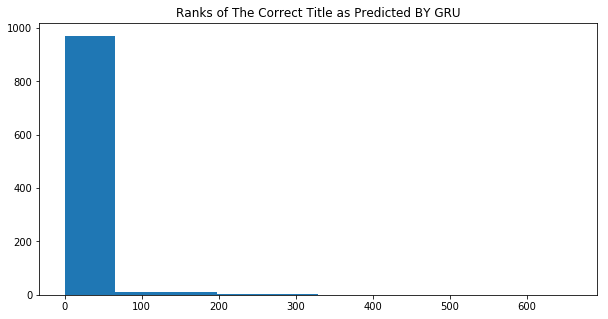

In [572]:
plt.figure(figsize=(10, 5))
plt.hist([rank for rank in ranks_lstm])
plt.title('Ranks of The Correct Title as Predicted By GRU')
plt.show()

In [221]:
ngram_inputs = []
for i in range (1, len(training_sequences[1])):
    ngram_seq = training_sequences[1][:i+1]
    ngram_inputs.append(ngram_seq)

In [222]:
ngram_inputs

[[246, 1890],
 [246, 1890, 625],
 [246, 1890, 625, 8380],
 [246, 1890, 625, 8380, 105],
 [246, 1890, 625, 8380, 105, 17],
 [246, 1890, 625, 8380, 105, 17, 3795],
 [246, 1890, 625, 8380, 105, 17, 3795, 19],
 [246, 1890, 625, 8380, 105, 17, 3795, 19, 71],
 [246, 1890, 625, 8380, 105, 17, 3795, 19, 71, 1890],
 [246, 1890, 625, 8380, 105, 17, 3795, 19, 71, 1890, 625],
 [246, 1890, 625, 8380, 105, 17, 3795, 19, 71, 1890, 625, 8380]]

In [223]:
training_sequences[1]

[246, 1890, 625, 8380, 105, 17, 3795, 19, 71, 1890, 625, 8380]

In [224]:
def ngram_sequence_generator(input_text):
    ngram_inputs = []
    for entry in input_text:
        for i in range(1, len(entry)):
            ngram_seq = entry[:i+1]
            ngram_inputs.append(ngram_seq)
            
    return ngram_inputs

In [225]:
ngram_input_sequences_training = ngram_sequence_generator(training_sequences)

In [365]:
ngram_input_sequences_training

[[602, 0],
 [602, 0, 9],
 [602, 0, 9, 5889],
 [602, 0, 9, 5889, 24],
 [602, 0, 9, 5889, 24, 7],
 [602, 0, 9, 5889, 24, 7, 602],
 [602, 0, 9, 5889, 24, 7, 602, 0],
 [246, 1890],
 [246, 1890, 625],
 [246, 1890, 625, 8380],
 [246, 1890, 625, 8380, 105],
 [246, 1890, 625, 8380, 105, 17],
 [246, 1890, 625, 8380, 105, 17, 3795],
 [246, 1890, 625, 8380, 105, 17, 3795, 19],
 [246, 1890, 625, 8380, 105, 17, 3795, 19, 71],
 [246, 1890, 625, 8380, 105, 17, 3795, 19, 71, 1890],
 [246, 1890, 625, 8380, 105, 17, 3795, 19, 71, 1890, 625],
 [246, 1890, 625, 8380, 105, 17, 3795, 19, 71, 1890, 625, 8380],
 [691, 14],
 [691, 14, 29],
 [691, 14, 29, 30],
 [691, 14, 29, 30, 1096],
 [691, 14, 29, 30, 1096, 2374],
 [691, 14, 29, 30, 1096, 2374, 3575],
 [691, 14, 29, 30, 1096, 2374, 3575, 499],
 [691, 14, 29, 30, 1096, 2374, 3575, 499, 1676],
 [691, 14, 29, 30, 1096, 2374, 3575, 499, 1676, 38],
 [691, 14, 29, 30, 1096, 2374, 3575, 499, 1676, 38, 14],
 [691, 14, 29, 30, 1096, 2374, 3575, 499, 1676, 38, 14, 63]

In [249]:
def generate_padded_sequence(input_sequences):
    input_sequences = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, 
                     padding="pre", truncating="post")
    
    #input_sequences = np.array(pad_sequences(input_sequences, maxlen=30, padding='pre'))
    
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    label = ku.to_categorical(label, num_classes=MAX_NB_WORDS+1)
    return predictors, label, max_sequence_len

In [250]:
predictors, label, max_sequence_len = generate_padded_sequences(ngram_input_sequences_training)

In [254]:
model_genn = Sequential()
model_genn.add(Embedding(nb_words+1,
                     WV_DIM,
                     mask_zero=False,
                     weights=[embedding_matrix],
                     input_length=MAX_SEQUENCE_LENGTH-1,
                     trainable=False))

model_genn.add(LSTM(200))
model_genn.add(Dropout(0.2))
model_genn.add(Dense(MAX_NB_WORDS+1, activation = 'softmax'))

model_genn.compile(loss='categorical_crossentropy', 
                   optimizer = 'adam',
                   metrics = ['accuracy']) 

In [256]:
len(predictors)

1716751

In [258]:
model_genn.fit(predictors[:10000], label[:10000], epochs = 100, verbose=2)

Epoch 1/100
 - 28s - loss: 6.8554 - acc: 0.0662
Epoch 2/100
 - 29s - loss: 6.8363 - acc: 0.0703
Epoch 3/100
 - 29s - loss: 6.8140 - acc: 0.0727
Epoch 4/100
 - 29s - loss: 6.7897 - acc: 0.0759
Epoch 5/100
 - 30s - loss: 6.7591 - acc: 0.0782
Epoch 6/100
 - 30s - loss: 6.7478 - acc: 0.0773
Epoch 7/100
 - 30s - loss: 6.7257 - acc: 0.0790
Epoch 8/100
 - 30s - loss: 6.6944 - acc: 0.0840
Epoch 9/100
 - 30s - loss: 6.6600 - acc: 0.0867
Epoch 10/100
 - 30s - loss: 6.6300 - acc: 0.0907
Epoch 11/100
 - 30s - loss: 6.5906 - acc: 0.0921
Epoch 12/100
 - 30s - loss: 6.5661 - acc: 0.0979
Epoch 13/100
 - 31s - loss: 6.5467 - acc: 0.0976
Epoch 14/100
 - 31s - loss: 6.4990 - acc: 0.0986
Epoch 15/100
 - 30s - loss: 6.4720 - acc: 0.0989
Epoch 16/100
 - 30s - loss: 6.4541 - acc: 0.0984
Epoch 17/100
 - 31s - loss: 6.4415 - acc: 0.0984
Epoch 18/100
 - 29s - loss: 6.4083 - acc: 0.0977
Epoch 19/100
 - 29s - loss: 6.3942 - acc: 0.1013
Epoch 20/100
 - 29s - loss: 6.3766 - acc: 0.1027
Epoch 21/100
 - 30s - loss: 6

In [624]:
def generate_text(seed_text, next_words, model, max_sequence_len):
    output_sequence = ''
    for _ in range(next_words):
        seed_text = seed_text.lower()
        seed_list = seed_text.split()
        token_list = [word_index.get(word)for word in seed_list]
        
        token_list= pad_sequences([token_list], maxlen=MAX_SEQUENCE_LENGTH-1, padding="pre")
        predicted = model.predict_classes(token_list, verbose=0)
        
        output_word = ""
        for word,index in word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " "+output_word
    for word in seed_list:
        output_sequence+=word+ ' '
    return output_sequence.strip()

In [633]:
generate_text('компьютер', 3, model_genn, 3)

'компьютер опт розница'